# Convolutional Neural Network (CNN) for Face Mask Detection

Quick hacky example of putting together a CNN for face mask detection.

In [1]:
import os

import itertools # To join a list of lists

import matplotlib.pyplot as plt # For general plotting

import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import torchvision
import torchvision.transforms as transforms

# Utility to visualize PyTorch network and shapes
from torchsummary import summary

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
random_seed = 7
np.random.seed(random_seed)
torch.manual_seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


## Data Setting

The intention of this "project" would be to classify whether people are either wearing masks correctly, incorrectly, or not wearing them at all. To create a model for this purpose, like a CNN classifier, we need an appropriate dataset. Pulling the Face Mask Detection (FMD) dataset for this example code from [FMD Kaggle](https://www.kaggle.com/datasets/shiekhburhan/face-mask-dataset), we can place it in the [data](../../data) directory of our code repository and load it from there.

The code below attempts to get a better understanding of the dataset's properties, e.g. the label distribution. It also performs pre-processing steps, like normalization, for later when we plan to feed this data into a classification model.

Dataset has N = 14536 samples
(array([0, 1, 2]), array([4000, 3831, 3797]))
(array([0, 1, 2]), array([1000,  958,  950]))

Labels corresponding to randomly drawn images from the training set:
without_mask	 with_mask	 without_mask	 with_mask	 with_mask	 incorrect_mask	 without_mask	 incorrect_mask	


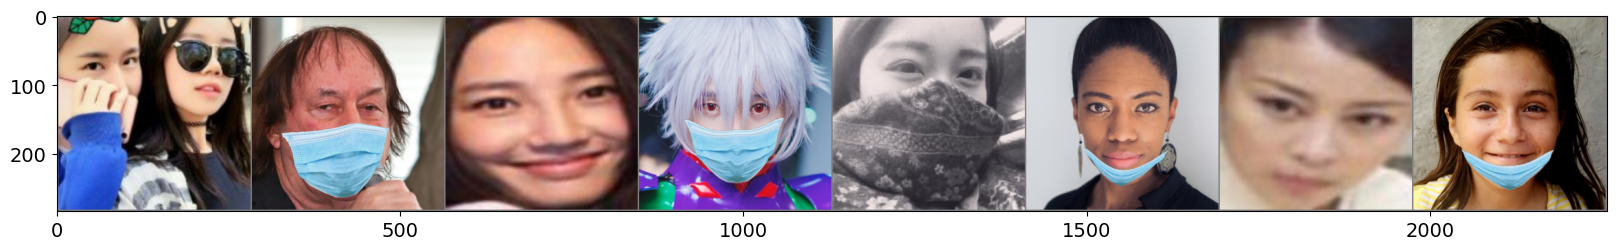

In [3]:
# Define how transform the data for processing in batches
transform = transforms.Compose([
        transforms.Resize([280,280]), # Resizing the image
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)) # 0.5 due to how torchvision data is in range [0,1]
    ])

# Specify the batch size for SGD
batch_size = 64
# Use the ImageFolder class, which is a generic dataloder useful when images stored in labelled directories
# Apply transform to images specified above, importantly converting "ToTensor"
dataset = torchvision.datasets.ImageFolder(root='../../data/FMD_DATASET', transform=transform)
# Specify classes for convenience in printing
classes = ('incorrect_mask', 'with_mask', 'without_mask')
print("Dataset has N = {} samples".format(len(dataset)))

# List of targets/labels for entire dataset
targets = dataset.targets
# Use sklearn function to split the data into training-test sets (80-20 split)
# Stratified ensures that same percentage of samples of each target class form a complete set
train_idx, test_idx= train_test_split(
    np.arange(len(targets)), test_size=0.2, random_state=random_seed, shuffle=True, stratify=targets)

# Printing the unique class labels in each split set and the number of occurrences per class
print(np.unique(np.array(targets)[train_idx], return_counts=True))
print(np.unique(np.array(targets)[test_idx], return_counts=True))

# Create training and test subsets based on split indices
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

# Define iterable for our newly created dataset and shuffle samples 
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

### Plotting stuff for visualization ###
fig = plt.figure(figsize=(20,20))
# Utility function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    img_np = img.numpy()
    plt.imshow(np.transpose(img_np, (1, 2, 0)))

# Get some random training dataset images
dataiter = iter(train_dataloader)
# Extract a batch
images, labels = next(dataiter)

# Show 8 images for display
num_display = 8
imshow(torchvision.utils.make_grid(images[:num_display]))
# Print labels as a concatenated string
print("\nLabels corresponding to randomly drawn images from the training set:")
print(" ".join(f'{classes[labels[j]]:5s}\t' for j in range(num_display)))

## Convolutional Neural Network (CNN) Classifier

Here let's define the CNN classifier we'll use for this application. Please look at the [PyTorch CNN tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) if you wish to reproduce such a classification model.

In [4]:
# Note that PyTorch uses NCHW (samples, channels, height, width) image format convention
class ConvNet(nn.Module):
    def __init__(self, in_channels, num_filters, out_classes, kernel_size=3):
        super().__init__()
        # Conv2D layer with 'same' padding so image retains shape
        self.conv1 = nn.Conv2d(in_channels, num_filters, kernel_size, padding='same')
        self.drop = nn.Dropout(p=0.2)
        #self.dropout = 
        # MaxPooling layer with 2x2 kernel size and stride 2
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(num_filters, num_filters*2, kernel_size, padding='same')
        self.fc1 = nn.Linear(num_filters*2*70*70, num_filters)
        self.fc2 = nn.Linear(num_filters, out_classes)

    def forward(self, x):
        # Non-linear ReLU activations between convolutional layers
        # Conv->ReLU->Pooling
        # 280x280 image -> 140x140 after pooling
        x = self.pool(self.drop(F.relu(self.conv1(x))))
        # 140x140 feature map -> 70x70 after pooling
        x = self.pool(self.drop(F.relu(self.conv2(x))))
        # Flatten all dimensions except batch (start_dim=1)
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

input_channels = images.shape[1]
# Note how IF using a GPU we have the .to(device) call on the model
# This will recursively convert all network parameters and buffers to CUDA tensors
model = ConvNet(input_channels, num_filters=16, out_classes=len(classes)).to(device)
# Dummy inputs so we can plot a summary of the neural network's architecture and no. of parameters
summary(model, input_size=(input_channels, 280, 280))

# Double check if model exists in the `models` directory
model_path = os.path.join(os.getcwd(), '../../models/cnn_fmd.pth')
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print("Loaded model from disk!")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 280, 280]             448
           Dropout-2         [-1, 16, 280, 280]               0
         MaxPool2d-3         [-1, 16, 140, 140]               0
            Conv2d-4         [-1, 32, 140, 140]           4,640
           Dropout-5         [-1, 32, 140, 140]               0
         MaxPool2d-6           [-1, 32, 70, 70]               0
            Linear-7                   [-1, 16]       2,508,816
            Linear-8                    [-1, 3]              51
Total params: 2,513,955
Trainable params: 2,513,955
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.90
Forward/backward pass size (MB): 32.30
Params size (MB): 9.59
Estimated Total Size (MB): 42.79
----------------------------------------------------------------


### Model Training

Using the PyTorch API makes training these complex neural network architectures relatively straightforward. You can refer to the other [MLP example](mlp_pytorch.ipynb) for a refresher on these PyTorch concepts.

In [5]:
def model_train_loader(model, dataloader, criterion, optimizer):
    size = len(dataloader.dataset)

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction error
        predictions = model(X)
        loss = criterion(predictions, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Report loss every 10 batches
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
            
def model_test_loader(model, dataloader, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Tracking test loss (cross-entropy) and correct classification rate (accuracy)
    test_loss, correct = 0, 0
    
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            predictions = model(X)
            test_loss += criterion(predictions, y)
            correct += (predictions.argmax(1) == y).type(torch.float).sum()
            
    test_loss /= num_batches
    correct /= size
    print(f"\nTest Error\n\tAccuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# The nn.CrossEntropyLoss() loss function automatically performs a log_softmax() to output
criterion = nn.CrossEntropyLoss()
# One is enough for my toy example...
num_epochs = 1
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_train_loader(model, train_dataloader, criterion, optimizer)
    model_test_loader(model, test_dataloader, criterion)
    
# Saving the model file 'cnn_fmd.pth' to the `models` directory
print("Saving model to disk!")
torch.save(model.state_dict(), model_path)

Epoch 1
-------------------------------
loss: 1.102448  [    0/11628]


/home/markz/anaconda3/envs/machine_learning/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


loss: 0.989606  [  640/11628]
loss: 0.910914  [ 1280/11628]
loss: 0.413372  [ 1920/11628]
loss: 0.253124  [ 2560/11628]
loss: 0.353570  [ 3200/11628]
loss: 0.223774  [ 3840/11628]
loss: 0.266720  [ 4480/11628]
loss: 0.133782  [ 5120/11628]
loss: 0.232013  [ 5760/11628]
loss: 0.267882  [ 6400/11628]
loss: 0.149155  [ 7040/11628]
loss: 0.229760  [ 7680/11628]
loss: 0.130067  [ 8320/11628]
loss: 0.235394  [ 8960/11628]
loss: 0.171839  [ 9600/11628]
loss: 0.117269  [10240/11628]
loss: 0.177272  [10880/11628]
loss: 0.244149  [11520/11628]

Test Error
	Accuracy: 93.2%, Avg loss: 0.235275 

Saving model to disk!


### Model Evaluation

Here are some quick examples of how to evaluate the model, starting with a qualitative assessment:


GroundTruth:
 without_mask	 incorrect_mask	 with_mask	 with_mask	 with_mask	 with_mask	 without_mask	 without_mask	

Predicted:
 without_mask	 incorrect_mask	 with_mask	 with_mask	 with_mask	 with_mask	 without_mask	 with_mask	


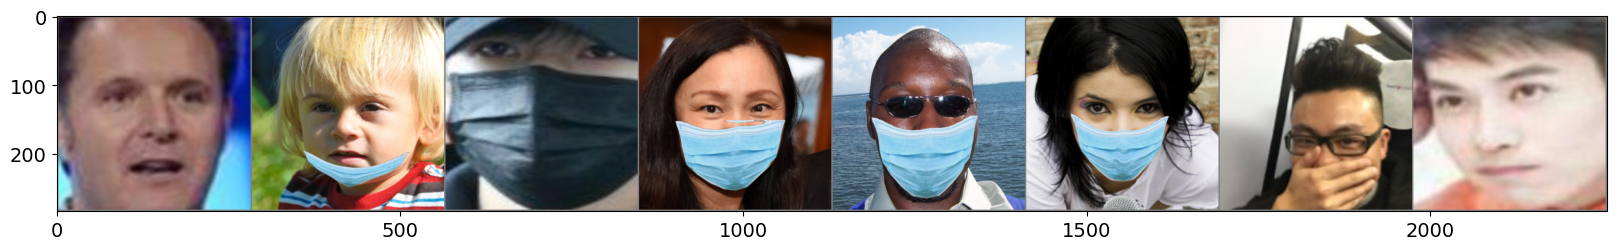

In [6]:
### Plotting stuff ###
fig = plt.figure(figsize=(20,20))

# Get some random test dataset images
dataiter = iter(test_dataloader)
# Extract a batch
images, labels = next(dataiter)
# Show images
imshow(torchvision.utils.make_grid(images[:num_display]))

outputs = model(images.to(device))
# Argmax take the most probable class
_, predicted = torch.max(outputs, 1)

# Print labels
print("\nGroundTruth:\n", " ".join(f'{classes[labels[j]]:5s}\t' for j in range(8)))

print("\nPredicted:\n", " ".join(f'{classes[predicted[j]]:5s}\t' for j in range(8)))

Ofcourse, it is also important to report quantitative metrics, like classification accuracy:

Accuracy of the network on the test set images: 93 %
Confusion Matrix (columns: True class, rows: Predicted class):


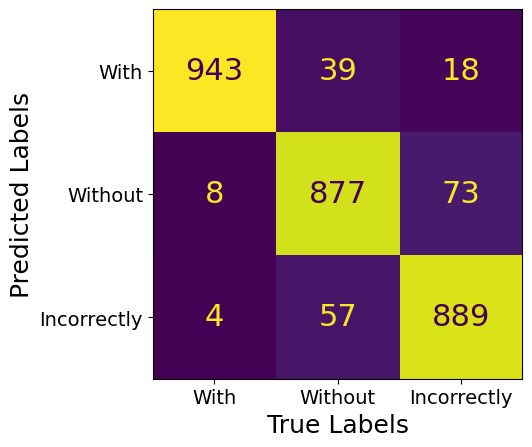

In [7]:
correct = 0

predicted_list = []
labels_list = []

# Since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    i = 0
    for data in test_dataloader:
        i += 1
        images, labels = data
        # Forward pass through network
        outputs = model(images.to(device))
        # Take most probable class
        _, predicted = torch.max(outputs.data, 1)
        predicted_list.append(predicted.cpu().detach().numpy())
        labels_list.append(labels.cpu().detach().numpy())
        
# Hacky conversions from a list of lists of arrays into joined numpy arrays
predicted_list = np.array(list(itertools.chain.from_iterable(predicted_list)))
labels_list = np.array(list(itertools.chain.from_iterable(labels_list)))
# Count up number of labels and correct predictions
correct = sum(predicted_list == labels_list)

print(f"Accuracy of the network on the test set images: {100 * correct // len(test_dataloader.dataset)} %")

print("Confusion Matrix (columns: True class, rows: Predicted class):")
conf_mat = confusion_matrix(labels_list, predicted_list);
conf_display = ConfusionMatrixDisplay.from_predictions(labels_list, predicted_list, display_labels=['With', 'Without', 'Incorrectly'], colorbar=False);
plt.xlabel("True Labels");
plt.ylabel("Predicted Labels");

Seems our classifier has most troubles with masks worn incorrectly being confused for no mask at all, or similarly, no mask cases being confused for incorrect mask wearing.

### Imbalanced Datasets

Please be aware that this is a nice and easy balanced dataset, as illustrated by the confusion matrix. IF you are dealing with imbalanced data settings where you possibly have a majority of samples belonging to one class, or very few instances of another class, then you need to report suitable metrics other than classification accuracy. In particular, comment on recall, precision and F1-scores. Maybe even consider plotting [precision-recall curves](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#:~:text=The%20precision%2Drecall%20curve%20shows,a%20low%20false%20negative%20rate.) and reporting on the area under the curve (AUC) metric. All of these measures will provide a better assessment of your classifier's ability to detect rare events.

There are also a variety of techniques you can apply to improve your classifier's ability to detect these rare events. First, check out sklearn's [compute_class_weights](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) routine to determine good class weights for your loss functions. Incorporating these weights into your optimization route, e.g., using the "weight" parameter of a [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) criterion, will replicate the effect of empirical risk minimization (ERM). In performing ERM, you will penalize more heavily any misclassifications of the rare/minority class, thus encouraging your model to prioritize their correct classification. Another technique to consider is re-sampling, where you can undersample (randomly) the majority class or oversample the minority class in your dataset.